# Classificação de imagens e objetos

> Atenção: este notebook deve ser executado com ambiente do tipo GPU para uma melhor performance.

## 1. Requerimentos

### 1.1 Bibliotecas

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV >=3.4.3
* Numpy >=1.18.1
* Keras >= 2.3.1
* Tensorflow >= 2.2.0

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [1]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 11779, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 11779 (delta 146), reused 333 (delta 133), pack-reused 11432
Receiving objects: 100% (11779/11779), 1.10 GiB | 26.47 MiB/s, done.
Resolving deltas: 100% (597/597), done.
Updating files: 100% (598/598), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [2]:
%cd fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/

/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado


Importação das bibliotecas.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import datetime

from os import listdir
from os.path import isfile, join, isdir, sep

from tqdm import tqdm

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Tensorflow
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers

import tensorflow as tf

sns.set_style("whitegrid", {'axes.grid' : False})

## 2. Deep learning a classificação de imagens

Para criar um modelo de Deep Learning para reconhecimento de imagens utilizando o conjunto de dados [COIL-100](https://www.kaggle.com/datasets/jessicali9530/coil100) da Columbia Object Image Library.

![](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-5-machine-learning-aplicado/imagens/coil100.jpg?raw=true)

In [ ]:
!rm -rf dataset-coil-100-adapted/

In [4]:
!git clone https://github.com/michelpf/dataset-coil-100-adapted

Cloning into 'dataset-coil-100-adapted'...
remote: Enumerating objects: 7315, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 7315 (delta 2), reused 2 (delta 2), pack-reused 7312
Receiving objects: 100% (7315/7315), 124.11 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (5/5), done.


### 2.1 Identificando as classes

Como um gerador de captchas nem sempre explora todo o alfabeto, vamos identificar exatamente quais as letras são utilizadas para listar todas as possíveis classes deste problema.

In [5]:
pasta_imagens_treino = "dataset-coil-100-adapted/dataset"
lista_arquivos_classes = [f for f in listdir(pasta_imagens_treino) if isdir(join(pasta_imagens_treino, f))]

lista_classes = list(set(lista_arquivos_classes))
print(lista_classes)
print(len(lista_classes))

['canned-tuna-fish', 'rubber-duck', 'tiny-vase', 'scotch-tape', 'yellow-racing-car-toy', 'iced-tea', 'antacid-tablets', 'green-cup', 'orange-soda', 'cinnamon', 'sport-car-toy', 'chicken-spice', 'floss', 'coke', 'strawberry', 'telephone', 'japanese-cup', 'cigarrette-box-marlboro', 'first-aid-kit', 'floater', 'soap-cup', 'flower-cup', 'yoyo', 'wood-triangle-piece', 'fishing-boat-toy', 'nuclear-waste', 'carrot-vase', 'blue-hook', 'cheeseburger', 'antacid-chewing-gum', 'correction-fluid-red', 'old-flower-cup', 'pain-relief-advil', 'truck-sport-car', 'stapler', 'pain-relief-tylenol', 'cream-cheese', 'cat-toy', 'pain-relief-anacin', 'juice-extractor', 'white-sport-car', 'pain-relief-dristan', 'red-sport-car', 'green-boat-toy', 'jar', 'plate', 'wood-piece-rectangular-toy', 'red-pepper', 'men-deodorant', 'red-sport-car-toy', 'frog-toy', 'vase', 'bulb-plug', 'cup', 'baby-powder', 'teapot', 'correction-fluid-green', 'floss-waxed', 'small-shovel', 'racing-toy', 'pear', 'orange-flower-cup', 'elect

In [6]:
train_datagen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='validation')

Found 5100 images belonging to 100 classes.
Found 2100 images belonging to 100 classes.


### 2.2 Treinamento

Colecionando imagens para treinamento e realizando pequenos ajustes para posterior uso na biblioteca de deep-learning do Keras.

Ao todo temos as seguintes quantidades de exemplos:

Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

Realizando a divisão de treinamento e validação.

### 2.3 Arquitetura

Partimos de um modelo simples que na maioria das vezes resolve problemas de OCR como esse. Como foi citado, identificações mais complexas utilizamos outras aboragens ou evolução de uma arquitetura inicial como esta.

In [7]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por
# colocar uma janela de kernel, navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(10, kernel_size=(3, 3), input_shape=(128, 128, 3), activation="relu"))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(10, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes)
# para uma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna
# a probabilidade por classe
model.add(Dense(100, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 10)        0         
                                                                 
 flatten (Flatten)           (None, 9000)              0

In [8]:
!pip install visualkeras==0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.5 MB/s eta 0:00:00


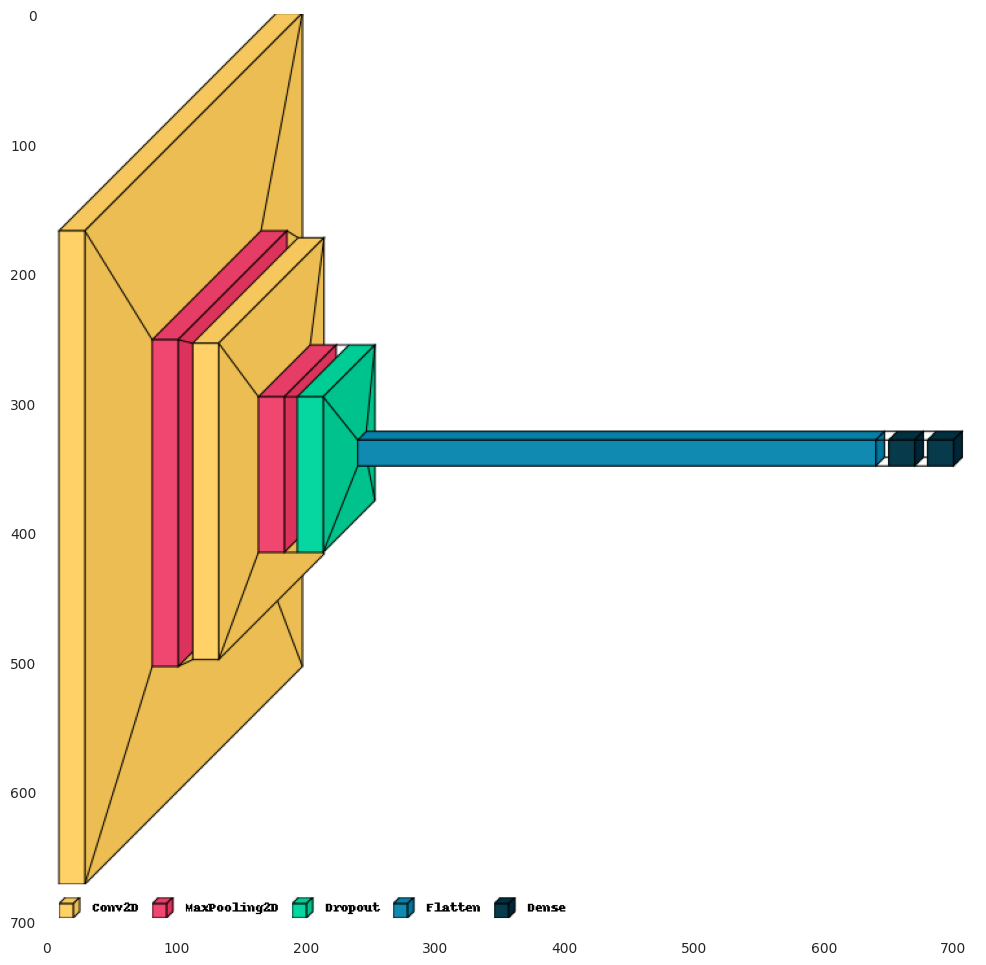

In [9]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file="graph.png")

image = cv2.imread("graph.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,30))
plt.imshow(image)

In [10]:
!pip install keras-vis==0.4.1

Trecho abaixo ajustado do [Kaggle](https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn/notebook) de Arpit Jain.

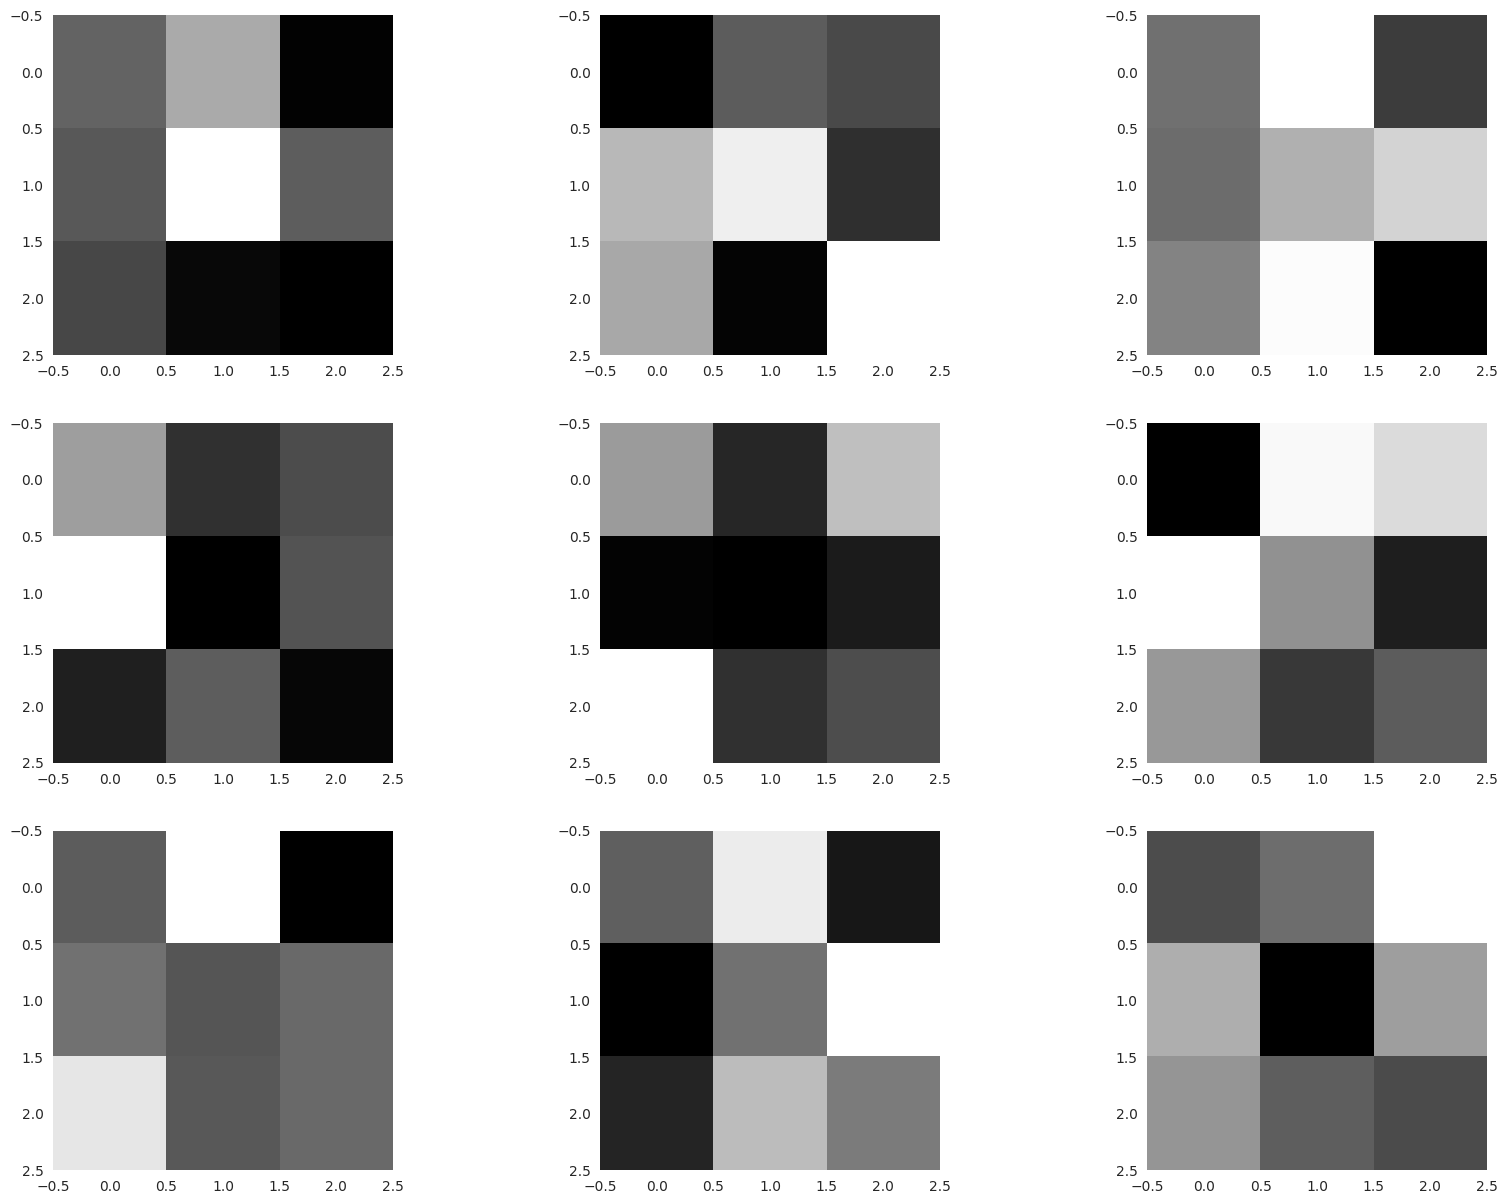

In [11]:
filters , bias = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix=1

fig = plt.figure(figsize=(20,15))

for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1


#plot the filters
plt.show()


In [ ]:
model.layers[0]

Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [62]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=3)

Epoch 1/3
160/160 [==============================] - 13s 80ms/step - loss: 0.0291 - accuracy: 0.9931 - val_loss: 0.8507 - val_accuracy: 0.8929
Epoch 2/3
160/160 [==============================] - 11s 68ms/step - loss: 0.0190 - accuracy: 0.9953 - val_loss: 0.8638 - val_accuracy: 0.8757
Epoch 3/3
160/160 [==============================] - 13s 82ms/step - loss: 0.0464 - accuracy: 0.9898 - val_loss: 1.4011 - val_accuracy: 0.8543


Os gráficos a seguir mostram convergência de acurácia para os dados de treinamento e validação.
Note que o valor do erro, diferentemente da acurácia, não é expressada em porcentagem, portanto erro < 1 é um ótimo valor.

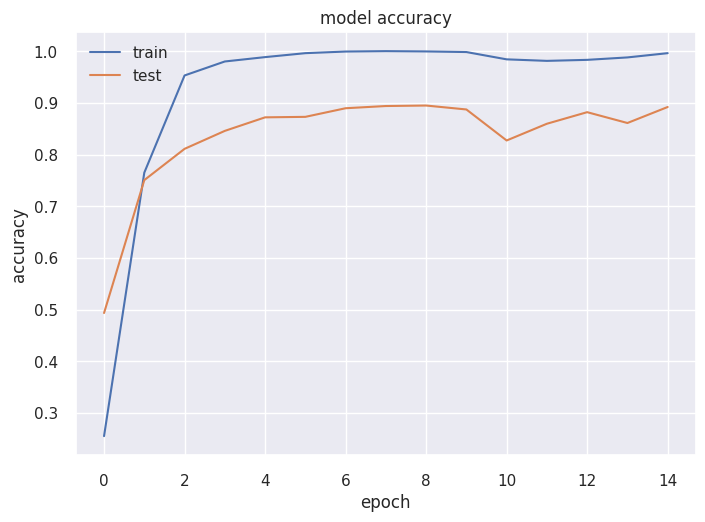

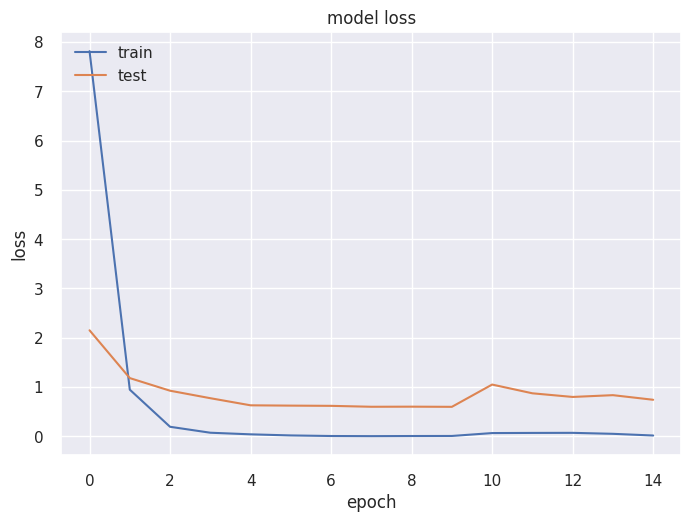

In [13]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [ ]:
# Salvando o modelo no formato HDf5
model.save("modelos/model.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights.h5")

Uma vez salvo o modelo, nesta etapa é só carregar.

In [ ]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model.h5")
model.load_weights("pesos/weights.h5")
model.summary()

### 2.4 Testes de validação
Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.
Para isso definimos uma função para normalizar uma imagem do captcha, para extrair os ruídos e posteriomente cada uma das suas letras.

Execução da função. Neste caso não fizemos a inversão da imagem pois as letras foram treinadas com o fundo branco.

In [88]:
imagens_teste_path = ["dataset-coil-100-adapted/dataset/alien-toy/20.png",
                      "dataset-coil-100-adapted/dataset/telephone/20.png",
                      "dataset-coil-100-adapted/dataset/cheeseburger/20.png"
                      ]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (128, 128))
    lista_imagem.append(imagem)

lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

In [89]:
pred_probs = model.predict(lista_imagem_array)
y_classes = pred_probs.argmax(axis=-1)

1/1 [==============================] - 0s 19ms/step


In [90]:
classes_labels = train_generator.class_indices
key_list = list(classes_labels.keys())
val_list = list(classes_labels.values())

In [91]:
key_list[val_list[y_classes[0]]]

'alien-toy'

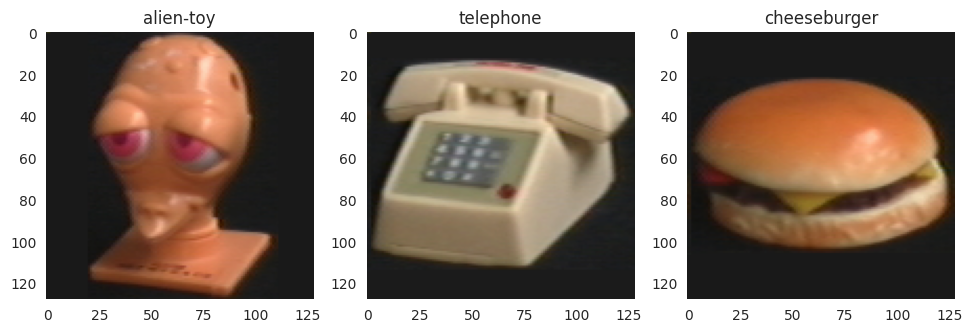

In [92]:
plt.figure(figsize=(20,10))

for i, imagem in enumerate(lista_imagem):
    plt.subplot(1,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(key_list[val_list[y_classes[i]]]))

plt.show()

Agora vamos investigar quais foram as regiões que foram mais atividadas, sendo por sua vez as mais relevantes e com a qual o modelo aprendeu mais. Isso é importante para evitarmos que os nossos modelos aprendam com as características erradas. Um bom exemplo é quando o modelo aprende a classificar uma girafa pelo backgroud árido das savana africanas.

Para a evidenciação destas regiões utilizamos a técnica GradCam, oriundo deste [paper](https://arxiv.org/abs/1610.02391) de Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra.

## 3. Transfer learning para reconhecimento de imagens

Técnica de transfer learning aplicado a deep learnig para classificação de imagens, utilizando classificados com pesos já treinados disponibilizados no Keras.

Foram utilizadas imagens representado dígitos de 0 a 9 com 500 imagens de cada uma, ao todo 5000 imagens.

As imagens de treinamento possuem 400 x 400 de resolução com 3 canais (imagens coloridas representadas em BGR ou RGB).

### 3.1 Geradores de imagens

Conjunto de dados utilizado foi [American Sign Language Digit Dataset](https://www.kaggle.com/rayeed045/american-sign-language-digit-dataset), disponível no Kaggle.

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Com a técnica de data augmentation ainda é possível crescer o número de imagens de treinamento ao incorporar as distorções citadas.

In [ ]:
!rm -rf dataset-american-sign-language-digit/

In [93]:
!git clone https://github.com/michelpf/dataset-american-sign-language-digit

Cloning into 'dataset-american-sign-language-digit'...
remote: Enumerating objects: 4619, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4619 (delta 1), reused 9 (delta 1), pack-reused 4610
Receiving objects: 100% (4619/4619), 111.48 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5001/5001), done.


In [94]:
imagem = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
imagem.shape

(400, 400, 3)

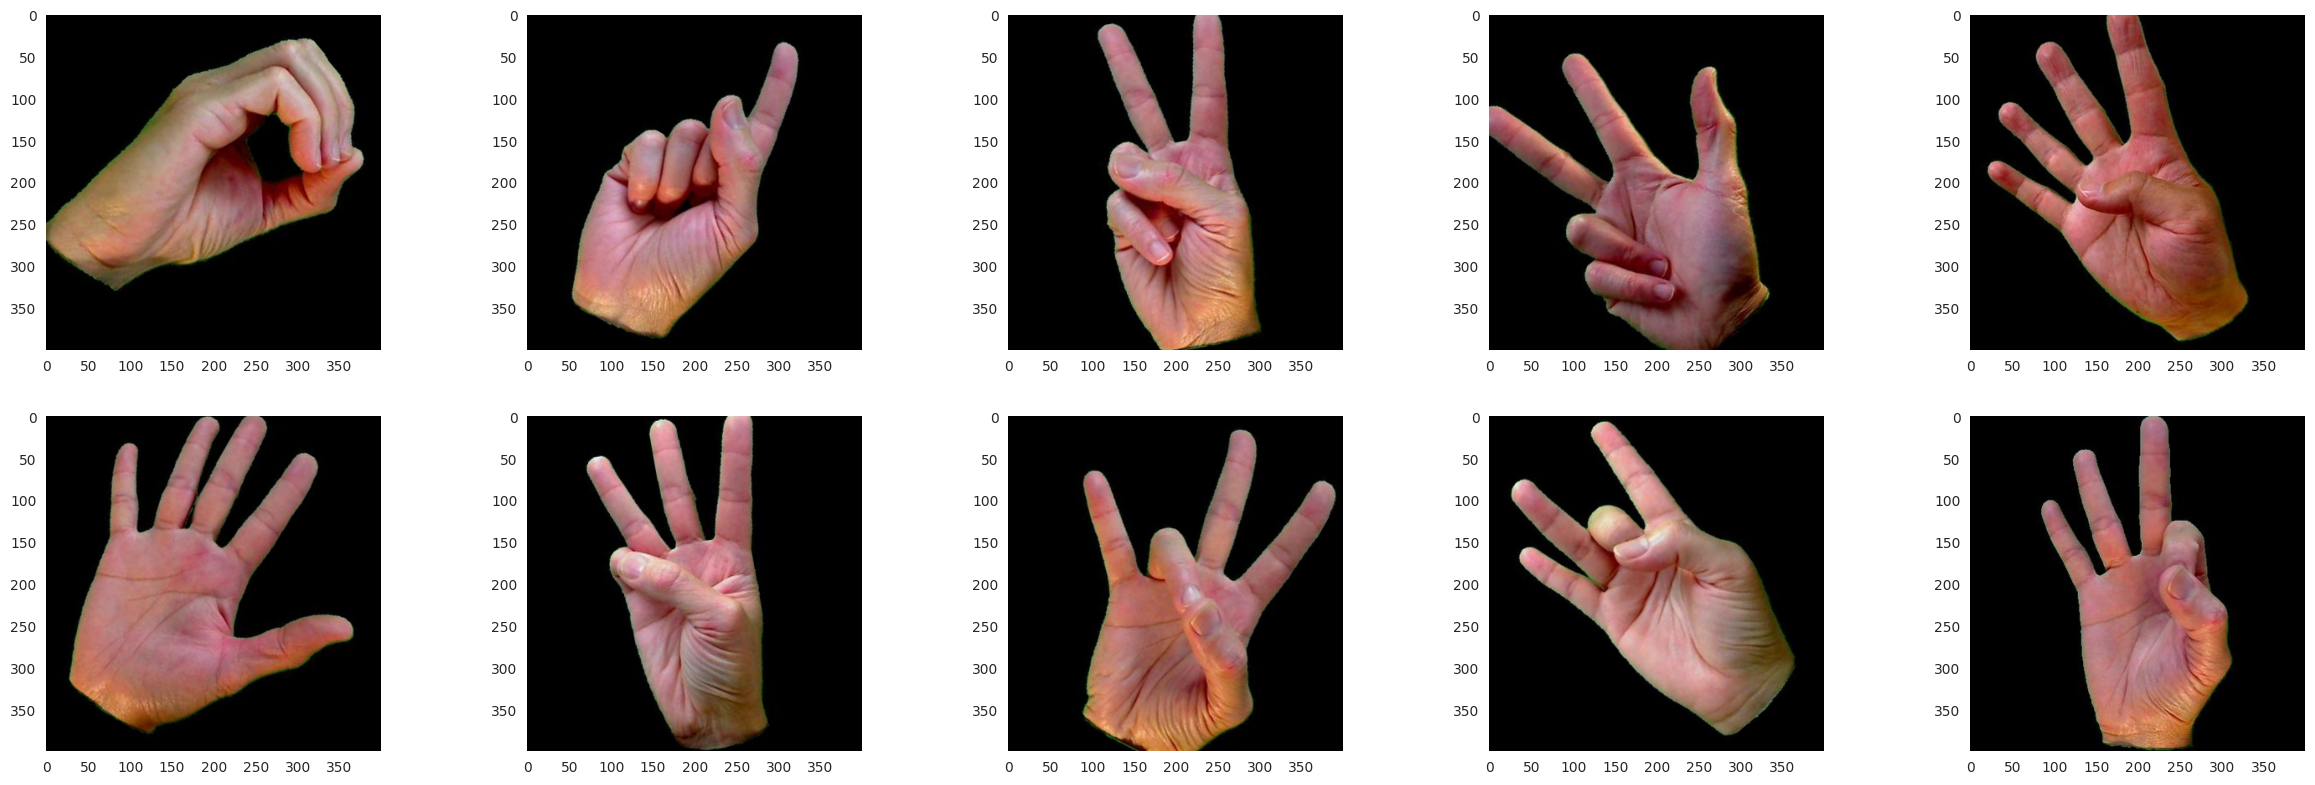

In [95]:
# Exibição das imagens
img1 = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("dataset-american-sign-language-digit/dataset/1/Sign 1 (2).jpeg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread("dataset-american-sign-language-digit/dataset/2/Sign 2 (3).jpeg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread("dataset-american-sign-language-digit/dataset/3/Sign 3 (4).jpeg")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread("dataset-american-sign-language-digit/dataset/4/Sign 4 (5).jpeg")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread("dataset-american-sign-language-digit/dataset/5/Sign 5 (6).jpeg")
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.imread("dataset-american-sign-language-digit/dataset/6/Sign 6 (8).jpeg")
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.imread("dataset-american-sign-language-digit/dataset/7/Sign 7 (9).jpeg")
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img9 = cv2.imread("dataset-american-sign-language-digit/dataset/8/Sign 8 (10).jpeg")
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img10 = cv2.imread("dataset-american-sign-language-digit/dataset/9/Sign 9 (11).jpeg")
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))

plt.subplot(4,5,1)
plt.imshow(img1)
plt.subplot(4,5,2)
plt.imshow(img2)
plt.subplot(4,5,3)
plt.imshow(img3)
plt.subplot(4,5,4)
plt.imshow(img4)
plt.subplot(4,5,5)
plt.imshow(img5)
plt.subplot(4,5,6)
plt.imshow(img6)
plt.subplot(4,5,7)
plt.imshow(img7)
plt.subplot(4,5,8)
plt.imshow(img8)
plt.subplot(4,5,9)
plt.imshow(img9)
plt.subplot(4,5,10)
plt.imshow(img10)

plt.show()

In [96]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='validation')

Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Exibindo as classes identificadas.

In [97]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### 3.2. Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [98]:
conv_base = VGG19(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [99]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0  

In [100]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3.3 Treinamento do modelo

In [101]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
110/110 [==============================] - 96s 793ms/step - loss: 1.0559 - accuracy: 0.6651 - val_loss: 0.7147 - val_accuracy: 0.7667
Epoch 2/5
110/110 [==============================] - 94s 861ms/step - loss: 0.2718 - accuracy: 0.9286 - val_loss: 0.4689 - val_accuracy: 0.8413
Epoch 3/5
110/110 [==============================] - 95s 862ms/step - loss: 0.1549 - accuracy: 0.9614 - val_loss: 0.3326 - val_accuracy: 0.8887
Epoch 4/5
110/110 [==============================] - 76s 695ms/step - loss: 0.1008 - accuracy: 0.9786 - val_loss: 0.2896 - val_accuracy: 0.9033
Epoch 5/5
110/110 [==============================] - 75s 684ms/step - loss: 0.0798 - accuracy: 0.9786 - val_loss: 0.2945 - val_accuracy: 0.9127


Armazenamento do modelo e carregamento do modelo pré-treinado.

In [ ]:
# salvando o modelo no formato HDf5
model.save('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights.h5')
with open('modelos/architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# carregando o modelo no formato HDf5
model = load_model('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-sign.json') as f:
    model = model_from_json(f.read())

model.load_weights('modelos/weights-sign.h5')

### 3.4 Predição nas imagens de teste

In [102]:
imagens_teste_path = ["dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/1/Sign 1 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/2/Sign 2 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/3/Sign 3 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/4/Sign 4 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/5/Sign 5 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/6/Sign 6 (20).jpeg",
                      "dataset-american-sign-language-digit/dataset/7/Sign 7 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/8/Sign 8 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/9/Sign 9 (1).jpeg"]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))
    lista_imagem.append(imagem)

In [103]:
lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [104]:
pred_probs = model.predict(lista_imagem_array)
probs = pred_probs.max(1)
probs

1/1 [==============================] - 3s 3s/step


array([0.9974868 , 0.99180096, 0.9923768 , 0.99998724, 0.9815154 ,
       0.99240196, 0.9984047 , 0.9997483 , 0.9800371 , 0.9508488 ],
      dtype=float32)

In [105]:
y_classes = pred_probs.argmax(axis=-1)
y_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<ipython-input-106-f34603061d6c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


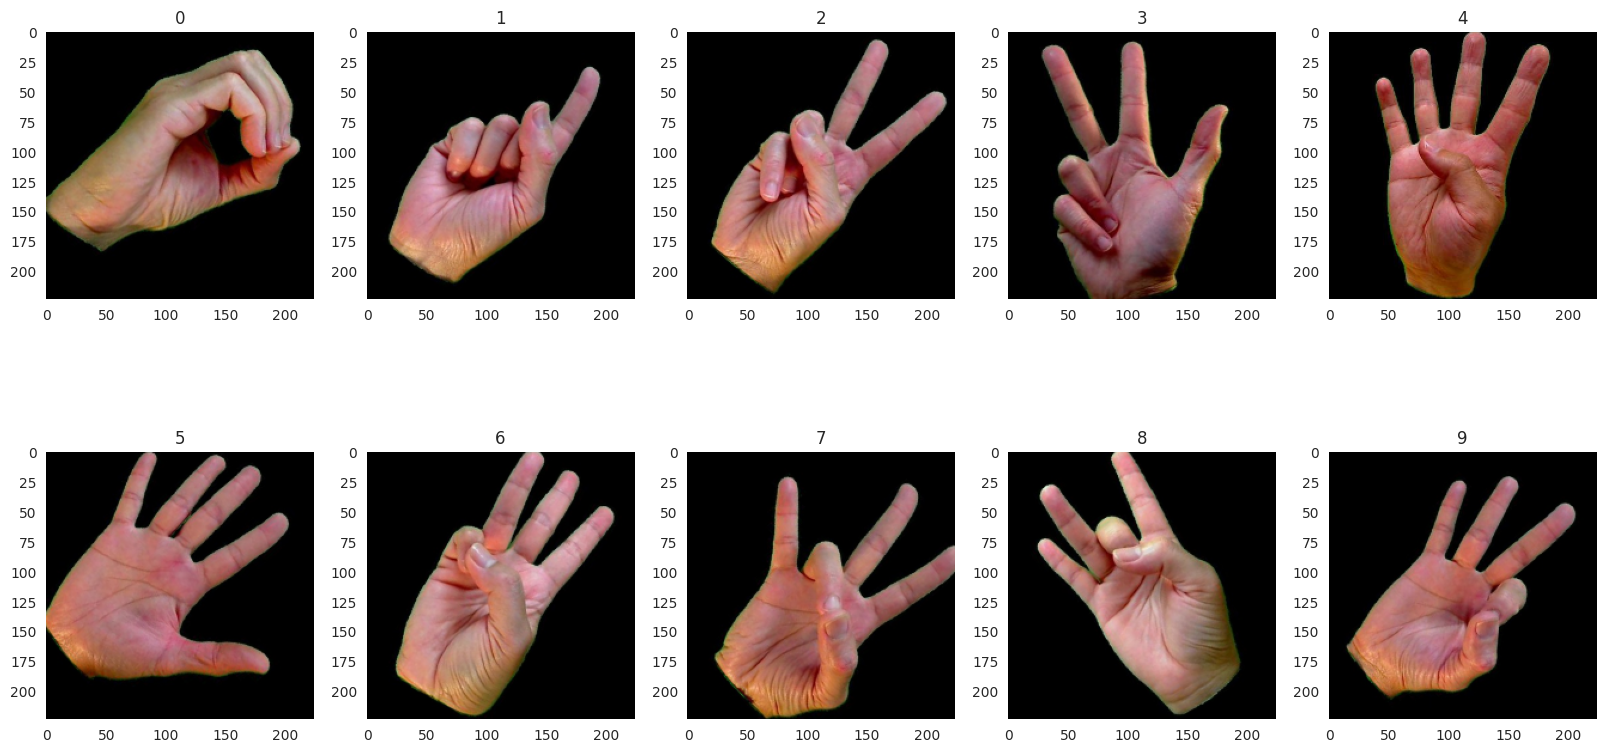

In [106]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(2,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(y_classes[i]))

plt.show()

## 4. Classificador de Objetos

Para a classificação de objetos iremos utilizar o modelo considerado o mais avançado, preciso e rápido da atualidade, que é a família YOLO (You Only Look Once).

O modelo YOLOv8 é o mais novo estado-da-arte para detecção de objetos, classificação de imagens e tarefas de segmentação de instâncias. O YOLOv8 foi desenvolvido pela Ultralytics, que também criou o influente e definidor de padrões da indústria, modelo YOLOv5. O YOLOv8 inclui várias mudanças arquiteturais e melhorias na experiência de desenvolvedor em relação ao YOLOv5.

### 4.1 Implementação

In [107]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 8.0 MB/s eta 0:00:00


In [108]:
from ultralytics import YOLO
import ultralytics

Validando se todas as configurações e GPU foram detectadas com sucesso.

In [109]:
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.3/78.2 GB disk)


Método via linha de comando. Nesse caso as predições serão salvas em um diretório pré-determinado conforme a saída do comando.

In [111]:
!yolo task=detect mode=predict model=yolov8s.pt conf=0.25 source="imagens/dog.jpg" save=True

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagens/dog.jpg: 352x640 15 persons, 6 dogs, 2 teddy bears, 359.6ms
Speed: 11.6ms preprocess, 359.6ms inference, 2436.4ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


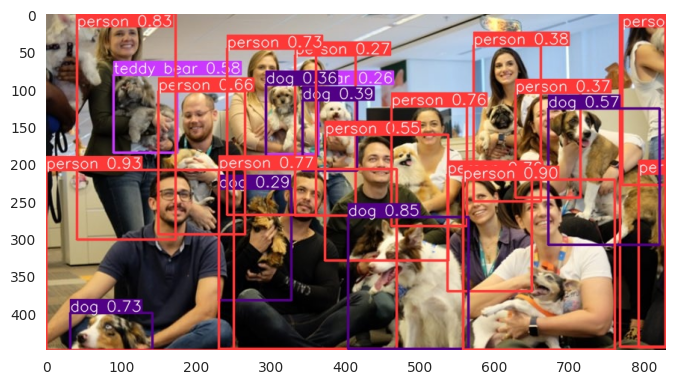

In [112]:
imagem_result = cv2.imread("runs/detect/predict/dog.jpg", cv2.IMREAD_COLOR)
imagem_result = cv2.cvtColor(imagem_result, cv2.COLOR_BGR2RGB)

plt.imshow(imagem_result)

Uma outra forma de realizar as predições é utilizando a biblioteca diretamente. Neste caso precisamos instanciar a classe YOLO.

In [113]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 80.6MB/s]


In [114]:
results = model.predict(source="imagens/dog2.jpeg", conf=0.25)


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagens/dog2.jpeg: 640x384 1 person, 1 car, 1 dog, 218.4ms
Speed: 2.3ms preprocess, 218.4ms inference, 874.5ms postprocess per image at shape (1, 3, 640, 384)


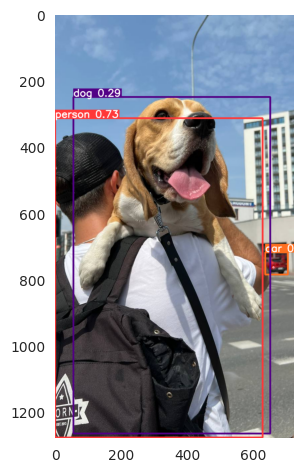

In [115]:
image_result = results[0].plot()
image_result = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)

plt.imshow(image_result)

Mesmo utilizando a classe diretamente no Jupyter, podemos optar por salvar os resultados da mesma maneira como fizemos via execução por linha de comando.

In [116]:
imagem = cv2.imread("imagens/office.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

results = model.predict(source=imagem, save=True, save_txt=True)


0: 448x640 4 persons, 1 bottle, 3 cups, 1 dining table, 6 laptops, 1 remote, 1 cell phone, 100.8ms
Speed: 3.6ms preprocess, 100.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels


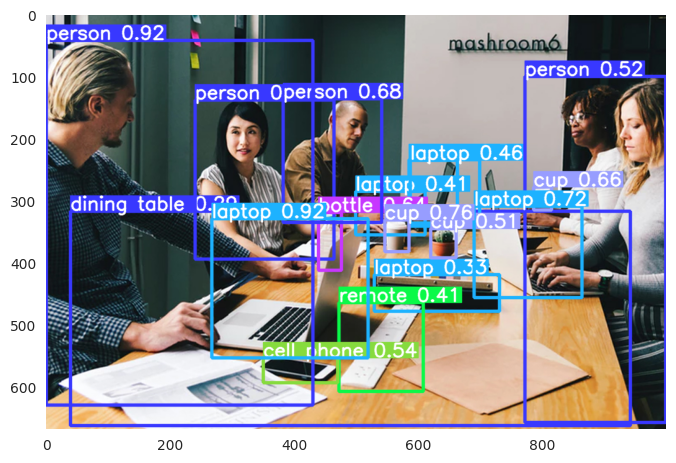

In [117]:
image_result = results[0].plot()

plt.imshow(image_result)

### 4.2 Treinamento de modelo customizado

Para treinar o modelo YOLOv8 basta usar apenas o comando ```train```. Os parâmetros necessários para essa função são:

* configuração de um arquivo yaml com as informações de caminho das imagens e classes
* épocas
* tamanho da imagem
* nome do seu modelo

Neste exemplo vamos treinar um modelo capaz de detectar buracos em ruas e estradas.

Utilizaremos o dataset [Potholes Detection for YOLOV4](https://www.kaggle.com/datasets/anugrahakbar/potholes-detection-for-yolov4) que foi organizado no repositório abaixo.

Os datasets padrão YOLO são compatíveis com todas as versões, mesmo este dataset originalmente ter sido utilizado para a versão V4.

In [118]:
!git clone https://github.com/michelpf/dataset-pothole

Cloning into 'dataset-pothole'...
remote: Enumerating objects: 3968, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3968 (delta 1), reused 6 (delta 0), pack-reused 3958
Receiving objects: 100% (3968/3968), 59.84 MiB | 40.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [119]:
!touch configs_modelo.yaml

In [128]:
%%writefile configs_modelo.yaml
path: '/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset'
train: 'train/'
val: 'test/'

nc: 1
names: ["pothole"]

Overwriting configs_modelo.yaml


In [129]:
arquivo_config  = "configs_modelo.yaml"

O treinamento do modelo também realiza em conjunto a validação com os dados separados do treinamento.

Ao final desta etapa é gerado diversas imagens da performance do modelo como curva F1, curva PR, curva P, curva R, matriz de confusão, dentre outras.

In [131]:
resultados = model.train(data=arquivo_config, epochs=3, imgsz=720, name='yolov8_pothole')

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=configs_modelo.yaml, epochs=3, patience=50, batch=16, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_pothole5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

train: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/train.cache... 1562 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1562/1562 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test.cache... 421 images, 0 backgrounds, 0 corrupt: 100%|██████████| 421/421 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8_pothole5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_pothole5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      3.66G      2.268      2.725      2.199         41        736: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]

                   all        421        970      0.487      0.429      0.411      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3       3.3G      1.788      2.009       1.75         54        736: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


                   all        421        970      0.438      0.387      0.348      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      3.34G      1.683      1.821      1.671         37        736: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


                   all        421        970      0.603      0.515      0.554      0.281

3 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/yolov8_pothole5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8_pothole5/weights/best.pt, 6.3MB

Validating runs/detect/yolov8_pothole5/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


                   all        421        970      0.597       0.52      0.554      0.281
Speed: 0.5ms preprocess, 3.3ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/yolov8_pothole5


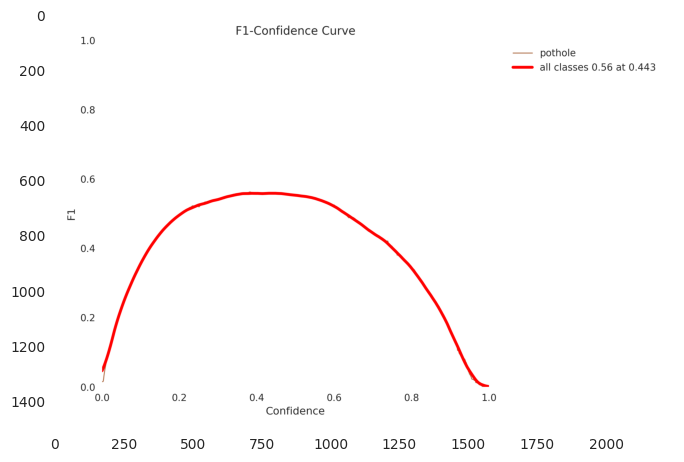

In [134]:
image = cv2.imread("runs/detect/yolov8_pothole/F1_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

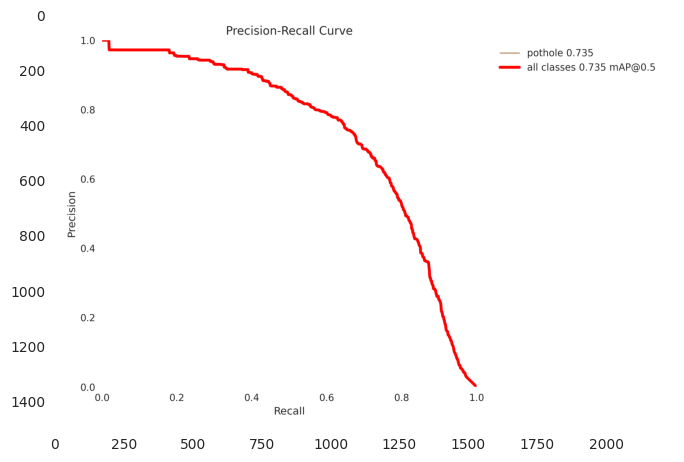

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/PR_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

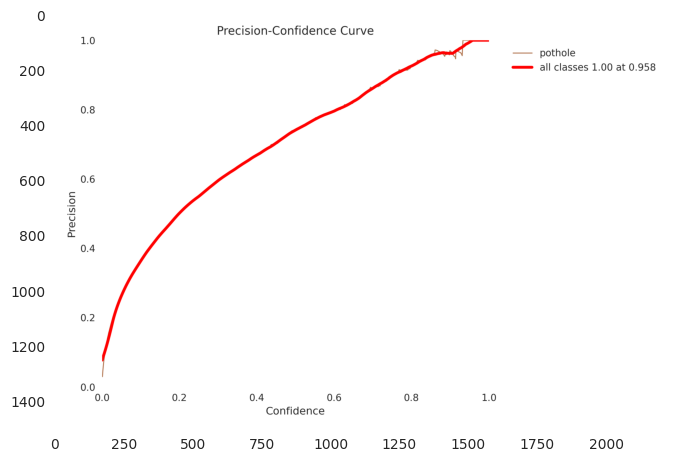

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/P_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

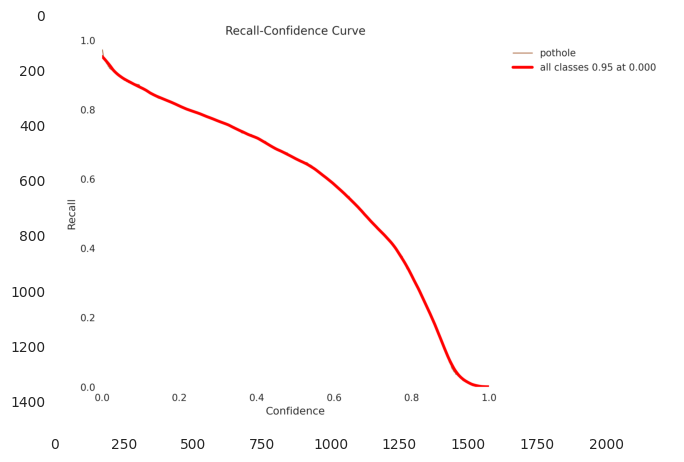

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/R_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

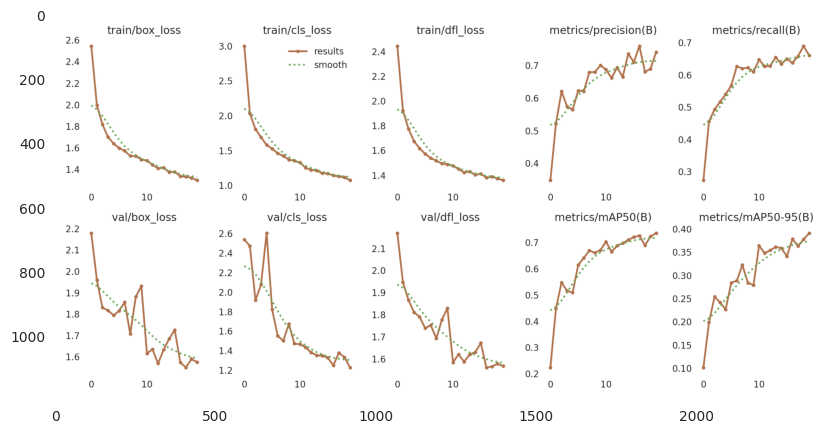

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/results.png", cv2.IMREAD_COLOR)
plt.figure(figsize=(10,5))
plt.imshow(image)

Realizando classificações em imagens que não fizeram parte do conjunto de dados.

In [135]:
dir_resultados = "runs/detect/yolov8_pothole5/weights/best.pt"

In [136]:
image = cv2.imread("imagens/buraco2.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [137]:
model = YOLO(dir_resultados)
results = model.predict(source=image, conf=0.25)


0: 576x736 4 potholes, 111.6ms
Speed: 3.7ms preprocess, 111.6ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 736)


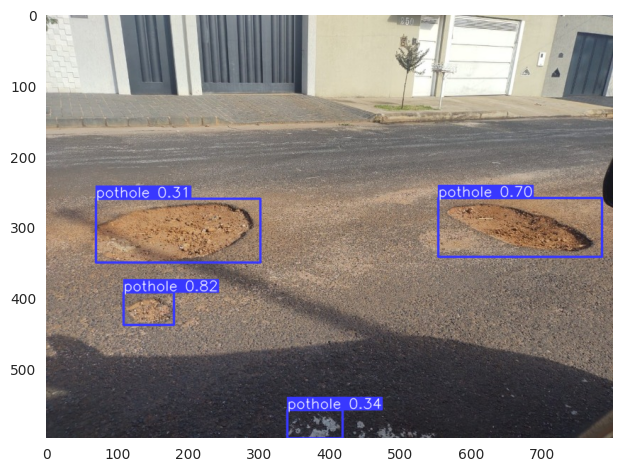

In [138]:
image_result = results[0].plot()

plt.imshow(image_result)

In [139]:
image = cv2.imread("imagens/buraco.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [140]:
results = model.predict(source=image, conf=0.25)


0: 512x736 1 pothole, 64.0ms
Speed: 3.6ms preprocess, 64.0ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 736)


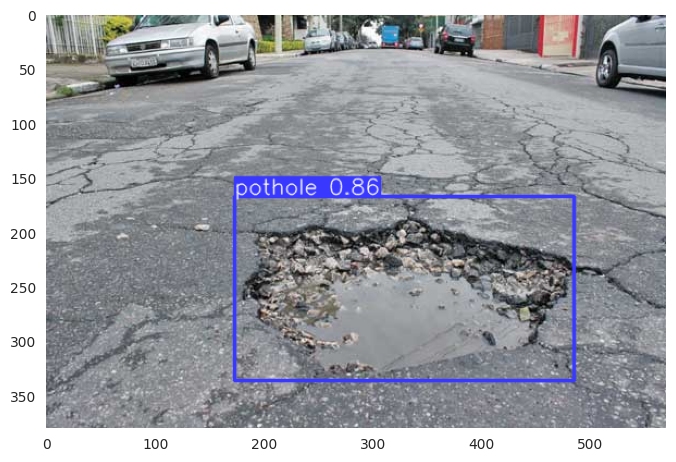

In [141]:
image_result = results[0].plot()

plt.imshow(image_result)